In [1]:
import os
import cv2
import json
import numpy as np

from d2go.runner import Detectron2GoRunner
from d2go.model_zoo import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

from detectron2.utils.visualizer import Visualizer
from d2go.utils.demo_predictor import DemoPredictor
from matplotlib import pyplot as plt

In [2]:
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

dataset_path = "/opt/infilect/dev/datasets/balloon_dataset/balloon"

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts(dataset_path+"/"+ d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"], evaluator_type="coco")
balloon_metadata = MetadataCatalog.get("balloon_train")

In [3]:
def prepare_for_launch():
    runner = Detectron2GoRunner()
    cfg = runner.get_default_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("mask_rcnn_fbnetv3a_C4.yaml"))
    cfg.MODEL_EMA.ENABLED = False
    cfg.DATASETS.TRAIN = ("balloon_train",)
    cfg.DATASETS.TEST = ("balloon_val",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("mask_rcnn_fbnetv3a_C4.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 1000    # 600 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg, runner

cfg, runner = prepare_for_launch()

In [4]:
model = runner.build_model(cfg)
runner.do_train(cfg, model, resume=False)

Arguments ['width_divisor', 'dw_skip_bnrelu', 'zero_last_bn_gamma'] skipped for op Conv2d
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 200) in the checkpoint but (2, 200) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 200) in the checkpoint but (4, 200) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_he

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.

{'model_final': CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': './output/model_final.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'FBNetV2C4Backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': [], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 64, 96, 128, 160]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'FBNetV2RpnHead', 'IN_FEATURES': ['trunk3'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1', 'BBOX_REG_LOSS_WEIGHT': 1.0, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 1.0),

In [5]:
# inference

In [6]:
predictor = DemoPredictor(model)

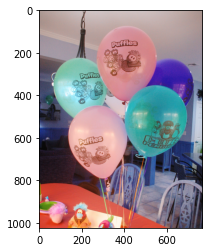

In [7]:
img_path = "/opt/infilect/dev/datasets/balloon_dataset/balloon/val/5603212091_2dfe16ea72_b.jpg"
im = cv2.imread(img_path)
plt.imshow(im)


In [8]:
outputs = predictor(im)

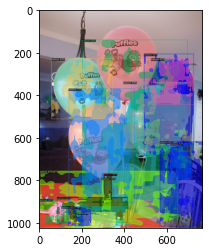

In [9]:
v = Visualizer(im[:, :, ::-1], balloon_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [11]:
outputs['instances']

Instances(num_instances=17, image_height=1024, image_width=768, fields=[pred_boxes: Boxes(tensor([[0.0000e+00, 8.3993e+02, 5.5910e+02, 1.0200e+03],
        [2.5419e+02, 9.1490e+01, 7.0294e+02, 4.5187e+02],
        [5.8288e+02, 2.1142e+02, 7.3617e+02, 8.0595e+02],
        [5.0243e+01, 2.2140e+02, 3.1927e+02, 5.3056e+02],
        [6.0155e+01, 2.0938e+02, 3.7847e+02, 7.9083e+02],
        [1.1569e+02, 4.3028e+02, 5.1066e+02, 8.4698e+02],
        [2.8870e+02, 8.4817e+01, 5.6852e+02, 7.7220e+02],
        [5.5417e+02, 7.9627e+02, 7.6478e+02, 1.0240e+03],
        [2.1260e+02, 9.6815e+01, 7.0684e+02, 9.1900e+02],
        [1.7968e+02, 1.6121e+01, 2.1008e+02, 2.4065e+02],
        [3.1889e+02, 7.0406e+02, 4.7508e+02, 1.0039e+03],
        [0.0000e+00, 8.9519e+02, 1.3325e+02, 9.9812e+02],
        [4.0182e+02, 3.1124e+02, 7.1599e+02, 6.8561e+02],
        [8.1989e-01, 1.4193e+02, 5.7050e+02, 9.5888e+02],
        [6.3827e+02, 6.8843e+02, 7.6326e+02, 8.2100e+02],
        [3.7980e+02, 3.7016e+02, 6.5132e